In [1]:
ls

3dfunctions.py            functions.py           README.md
5ow3.cif                  functions.pyc          ssfunctions.ipynb
5ow3.pdb                  Hashprotocol.ipynb     SSfunctions.py
config.py                 learn.py               SSfunctions.pyc
config.pyc                learnssmodel.py        SSfunctions_window.py
daskClusterLSF.py         lsfconfig.py           sspredictor.py
Dataset.py                physicalpropTable.csv  test.py
distributedTensorFlow.py  preprocessSSdata.py    test.pyc
examples/                 __pycache__/


In [1]:
import pandas as pd
import numpy as np
import keras
from Bio import SeqIO
import glob
import pdb
import functools


from sklearn.preprocessing import OneHotEncoder
from keras.models import Model
from keras.layers import Input, Dense , LSTM , Bidirectional

def protsec2numpy(sec, windowlen, propdict=None, verbose= False):
    #window should be an odd number
    #slice up the sequence into window sized chunks
    padding = (windowlen-1)/2
    try:
        originallen = len(sec)
    except TypeError:
        return None
    sec = ['-']*int(padding) + list(sec) + int(padding)*['-']
    sechunks=  [ [ x for x in str(sec[i:i + windowlen]) ]  for i in range(0, originallen)]
    return sechunks

def seq2vec(seq, propdict, verbose = False):
    #countmat is length of sequence
    propmat = np.zeros(( len(propdict) , len(seq) ))
    seqvec = np.asarray( [char for char in seq] )
    for i,prop in enumerate(propdict):
        vals = np.vectorize(propdict[prop].get)(seqvec)
        propmat[i,:] = vals.ravel()
    return propmat

def econdedDSSP(ssStr,intdico,encoder):
    '''
    H = alpha-helix
    B = residue in isolated beta-bridge
    E = extended strand, participates in beta ladder
    G = 3-helix (310 helix)
    I = 5 helix (pi-helix)
    T = hydrogen bonded turn
    S = bend
    '''
    try:
        intvec = np.asarray([ intdico[char] for char in ssStr])
        onehot = encoder.transform(intvec.reshape(-1, 1))
        return onehot
    except:
        #print(ssStr)
        return(ssStr)


Using TensorFlow backend.


In [2]:
import csv
def loadDict(csvfile):    
    with open(csvfile , 'r') as filestr:
        final = {}
        propdict= csv.DictReader(filestr)
        for row in propdict:
            for key in row.keys():
                if key != 'letter Code' and key!= 'Amino Acid Name' and key!= '':
                    if key not in final:
                        final[key]={}
                    final[key][row['letter Code']] = float(row[key])
    return final


def datagenerator(fastas , n=100 , windowlen= 13, embeddingprot=None , embeddingSS=None):
    #yield string for x and y to make a df block of n sequences to learn with
    for fasta in fastas:
        fastaIter = SeqIO.parse(fasta, "fasta")
        seqDict={}
        for seq in fastaIter:
            chainID = str(seq.description)
            ID = chainID[0:6]
            if ID not in seqDict:
                seqDict[ID]= {}
            if 'secstr' in seq.description:
                seqDict[ID]['SS']= ''.join(seq.seq)
            else:
                seqDict[ID]['AA']= ''.join(seq.seq)

            if len(seqDict)>n:
                df = pd.DataFrame.from_dict(seqDict, orient= 'index')
                yield df
                seqDict={}




#init encoder for ss
sspath = '/home/cactuskid/Dropbox/machine_learning/SSdataset/'
fastas = glob.glob(sspath +'*.txt')
print(fastas)

#window of amino acids to inspect in lstm
windowlen = 13

#first part of the network, layered lstm
LSTMoutdim = 30
LSTMlayers = 3
#second part of the network, dense decoder
Denselayers = 3
Denseoutdim = 30
#save itnerval
saveinterval = 100
verbose = True

proppath = '/home/cactuskid/Dropbox/machine_learning/physicalpropTable.csv'
propdict = loadDict(proppath)

#pdb.set_trace()


encoder = OneHotEncoder()
encoder.fit( np.asarray( np.asarray(range(7)).reshape(-1,1) ) )



intdico = { charval : int(i) for i,charval in enumerate(['H', 'B', 'E', 'G', 'I', 'T', 'S'] ) }
ssencoder = functools.partial( econdedDSSP , intdico= intdico , encoder = encoder)
prot2sec = functools.partial( protsec2numpy , windowlen= windowlen , propdict= propdict )
generator = datagenerator(fastas, n = 10 , windowlen= windowlen ,  embeddingprot = prot2sec , embeddingSS = ssencoder)

testdf = next(generator)

[]


FileNotFoundError: [Errno 2] No such file or directory: '/home/cactuskid/Dropbox/machine_learning/physicalpropTable.csv'

In [ ]:
print(testdf)

In [ ]:
row = next(testdf.iterrows())

In [ ]:
print(row[1]['AA'])

rowout = protsec2numpy(row[1]['AA'], 11, propdict=None, verbose= False)

In [ ]:

from array import array
''.join(rowout[0])


In [3]:
from Bio.PDB import *
import numpy as np
from matplotlib import pyplot as plt


In [4]:
p = PDBParser()
structure = p.get_structure("50w3", "./5ow3.pdb")
model = structure[0]
print(model)




<Model id=0>


In [5]:
header = [ 'DSSP_index' , 'Amino_acid' , 'Secondary_structure' , 'Relative_ASA', 'Phi',
          'Psi' , 'NH-->O_1_relidx' ,'NH-->O_1_energy' , 'O-->NH_1_relidx', 'O-->NH_1_energy',
          'NH-->O_2_relidx' ,'NH-->O_2_energy', 'O-->NH_2_relidx' ,'O-->NH_2_energy']

import pandas as pd
import time

start = time.time()

dssp = DSSP(model,"./5ow3.pdb", dssp='mkdssp')

print( time.time()- start)

start = time.time()

df = pd.DataFrame.from_dict({k[1]:dict(zip( header, dssp[k])) for k in list(dssp.keys()) }, orient= 'index')

print(time.time()-start )


print(df)


0.14412260055541992
0.012952566146850586
         DSSP_index Amino_acid Secondary_structure  Relative_ASA    Phi  \
  25              1          I                   -      0.124260  360.0   
  26              2          Q                   E      0.494949 -131.5   
  27              3          I                   E      0.307692  -80.9   
  28              4          L                   E      0.518293  -79.1   
  29              5          S                   E      0.407692 -159.2   
  30              6          K                   E      0.434146 -129.6   
  31              7          S                   E      0.407692 -146.7   
  32              8          K                   E      0.560976  -93.4   
  33              9          L                   E      0.597561 -146.4   
  34             10          E                   E      0.623711  -85.9   
  35             11          K                   E      0.370732  -91.9   
  36             12          C                   E      0.4

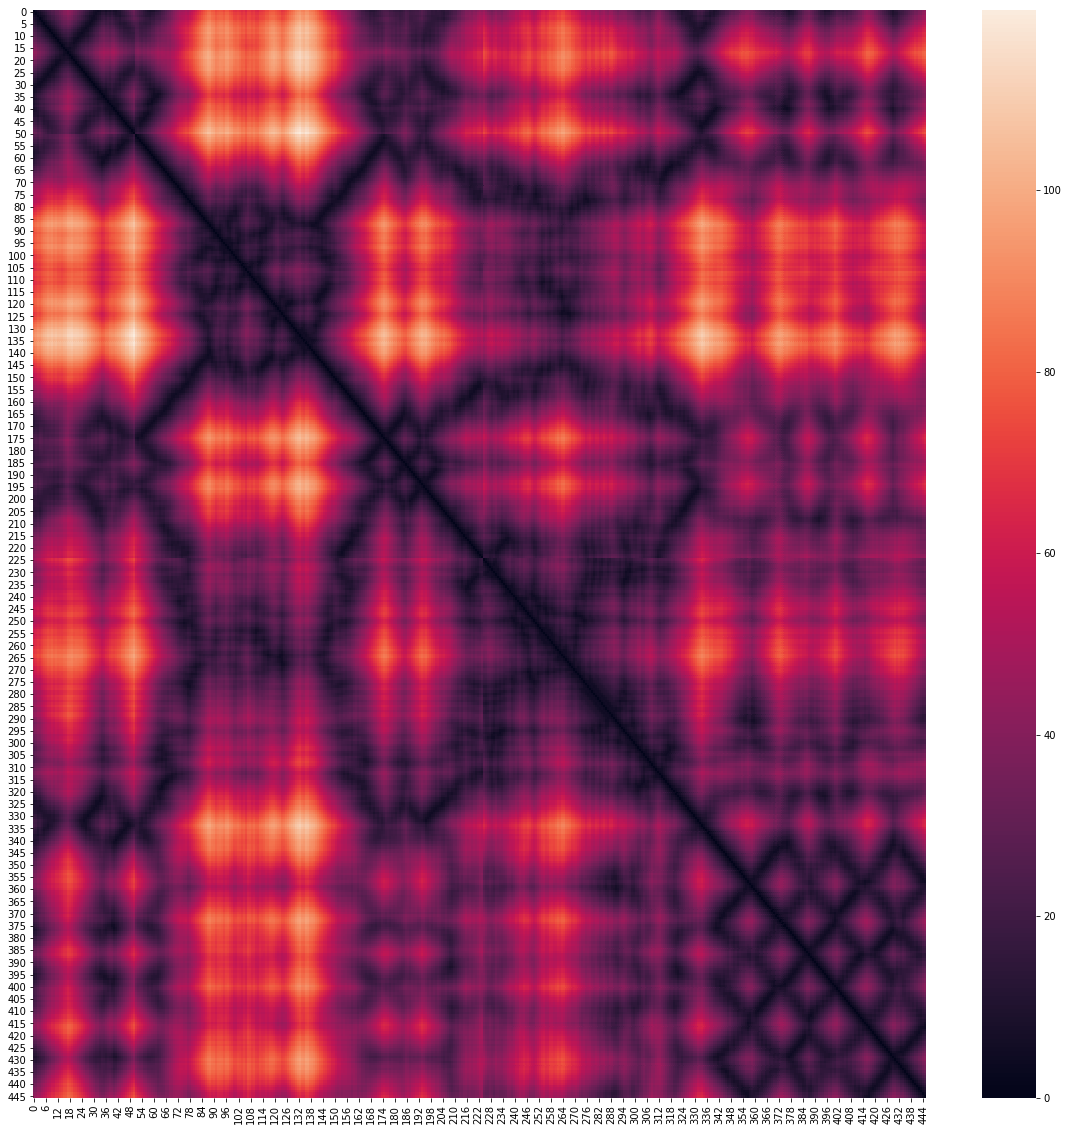

[[8118680.68939777+0.00000000e+00j  208947.48346002-5.03412923e+05j
  -207816.9588473 +5.24649409e+03j ...  176517.01049097-2.28870522e+05j
  -207816.9588473 -5.24649409e+03j  208947.48346002+5.03412923e+05j]
 [ 208947.48346002-5.03412923e+05j  -23019.20334111-5.18106700e+05j
   -31432.0366216 -3.87390172e+05j ...  255179.98028674-3.47437749e+05j
  -363391.58978531+1.12699529e+04j -744603.70082436-8.36735126e-11j]
 [-207816.9588473 +5.24649409e+03j  -31432.0366216 -3.87390172e+05j
   -90485.35995751-1.71185359e+05j ...  163162.21404254-3.67817261e+05j
  -378994.09175181+0.00000000e+00j -363391.58978531-1.12699529e+04j]
 ...
 [ 176517.01049097-2.28870522e+05j  255179.98028674-3.47437749e+05j
   163162.21404254-3.67817261e+05j ...  825988.18974964-2.89501008e+03j
  -152750.03273838-4.00725766e+05j -237631.67167884-4.15264078e+05j]
 [-207816.9588473 -5.24649409e+03j -363391.58978531+1.12699529e+04j
  -378994.09175181+0.00000000e+00j ... -152750.03273838-4.00725766e+05j
   -90485.35995751+

/home/cactuskid/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log


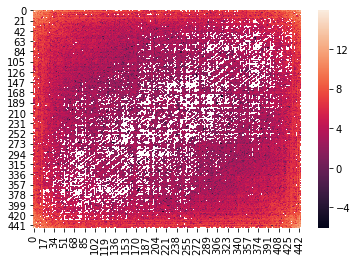

(446, 446)


/home/cactuskid/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


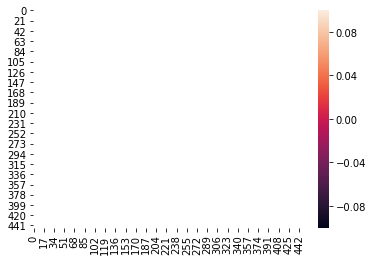

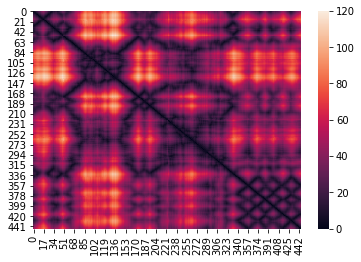

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt

ppb = CaPPBuilder()
alphas = [ r for a in  ppb.build_peptides(structure) for r in a ]

dist = np.asarray([[np.linalg.norm(a1['CA'].get_vector() - a2['CA'].get_vector()) if i < j else 0 for i,a1 in enumerate(alphas)] for j,a2 in enumerate(alphas) ] )
dist += dist.T

fig, ax = plt.subplots(figsize=(20,20))

sns.heatmap(dist , ax =ax)
plt.show()

spectro = np.fft.fft2(dist)
print(spectro)

imaginary  = spectro - spectro.real
real = spectro.real
sns.heatmap( np.log(real) )
plt.show()


print(spectro.shape)

sns.heatmap(np.log( np.conj(imaginary).real )) 
plt.show()

sns.heatmap( np.fft.ifft2(spectro).real)
plt.show()

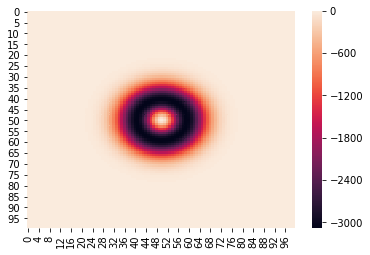

In [7]:
from scipy import signal
import math
widths = np.arange(1, 31)

%matplotlib inline
def rickerfun( a, x , y):    
    A = 2/(math.pi*a)   
    return A*(1 - .5*(x**2 + y**2)/a**2) * math.exp(-(x**2 + y**2) / 2*a**2 )

def ricker2d( points, a ):
    X = range( int(-points/2 ), int(points/2))
    Y = range( int(-points/2 ), int(points/2))
    kernel = np.asarray([[ rickerfun(a , x , y) for y in list(Y) ]  for x in list(X)])
    return kernel

sns.heatmap(ricker2d(points= 100 , a = .15))

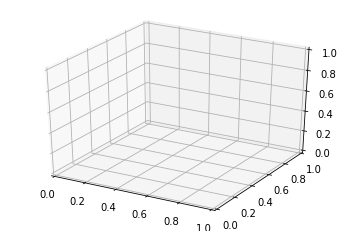

In [8]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

points = 100
Z = np.ravel( ricker2d(points= points , a = .15) )

plt.show()


In [38]:

cwtmatr = signal.cwt(dist, ricker2d, widths)

sns.heatmap(cwtmatr)

ValueError: could not broadcast input array from shape (446,446) into shape (446)

In [20]:
import pywt
print(pywt.wavelist(kind='discrete'))
coeffs = pywt.dwt2(dist, 'haar')
cA, (cH, cV, cD) = coeffs

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


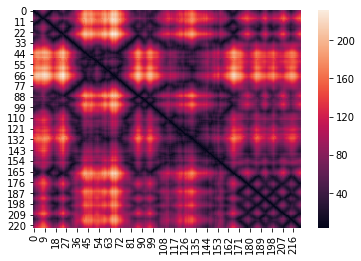

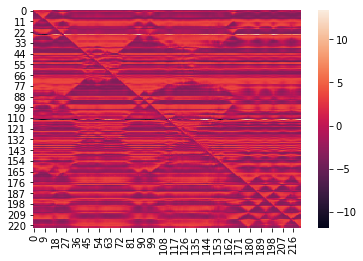

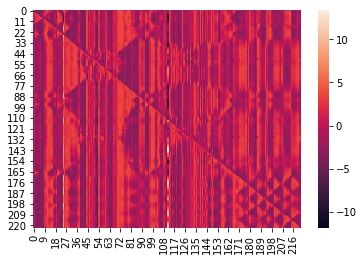

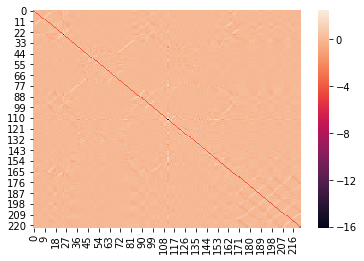

In [21]:
for mat in [cA, cH, cV, cD ]:
    sns.heatmap(mat)
    plt.show()